# Tutorial 4: Regression (Linear and Non-Linear)

In engineering problems (be it reactor design or process control), we are often tasked with finding a **model** of the system, which describes the dynamic physical/chemical/mechanical etc. relationships between **inputs** and **outputs**. For example, in a combined reactor design/control problem, the inputs to the process can be the flowrates, concentrations, ph, etc., while the output of the process can be the final conversion or yield of a chemical species.

In the simplest case where the **inputs** and **outputs** form a linear model between them, the technique of **linear least squares** is a popular approach to find the model parameters, or *weights*.

Consider the linear equation $y=mx+b$ which relates **outputs** $y$ to **inputs** $x$. The model *weights* or *parameters* are the *slope* $m$ and the *intercept* or *bias* $b$, which can be tweaked in order to improve the model fit. The concepts of underfitting/overfitting and bias-variance tradeoff are covered in another notebook, so for now let's just think of *fit* as *how well the model explains the relationship between input and output*. Our goal is to find the *best* values of $w$ and $b$ that describe the system.

Before we discuss how to do that, however, let's first consider the generalization of the linear equation, which applies to **Multi-Input-Single-Output (MISO)** systems. The **Single-Input-Single-Output (SISO)** system is a special case of this, so if we understand what happens in MISO, SISO is very easy. In the MIMO case, the inputs are represented by a $N$-by-$d_x$ matrix $X^*$ (where $N$ is the total number of datapoints or samples, and $d_x$ is the total number of input variables), and the outputs are represented by a $N$-by-$1$ column vector. The linear relationship is:

$$y=X^*W^*+\mathbf{1}_{N}\cdot B$$

where $W^*$ is an $d_x$-by-$1$ matrix containing the slope terms, $\mathbf{1}_{N}$ is an $N$-by-$1$ column vector of ones, and $B$ is a scalar term containing the bias, respectively. Since the bias term $\mathbf{1}_{N}\cdot B$ is somewhat annoying to carry around, the previous equation is usually compactly written as:

$$y=XW$$

where $X$ is simply $X^*$ with a column of ones appended to it on the left, and $W$ is $W^*$ with an extra scalar term appended to it from the top. This scalar term is equivalent to $B$.

The above equation actually never holds perfectly. In other words, $y$ is always going to be slightly different compared to $XW$. However, we can think of $XW$ as the *estimate* of $y$, or in proper terminology, the *prediction* of $y$, expressed as $\hat{y} = XW$. Therefore, when we calculate $y-\hat{y} = y-XW$, we are calculating the *residual* between the actual value of $y$ and its prediction $\hat{y}$. 

Knowing this, the first approach you may think of is to *minimize* the residual, so as to find the $W$ that *best-fits* the data. This is exactly what linear least-squares does. The minimization objective is written as:

$$\underset{W}{min}\lvert \lvert XW-y \rvert \rvert_2^2$$

where $\lvert \lvert A \rvert \rvert_2$ represents the $L_2$-norm of a column vector $A$. Finding the minimum to this is actually relatively easy, because this resembles a *convex* quadratic equation, which we know from calculus can be minimized by setting the derivative to zero. To do this, first we expand the previous equation as:

$$ \lvert \lvert XW-y \rvert \rvert_2^2 = (XW-y)^{\top}(XW-y) = (W^{\top}X^{\top}-y^{\top})(XW-y)=W^{\top}X^{\top}XW-W^{\top}X^{\top}y-y^{\top}XW+y^{\top}y$$

Differentiation the last equation in the previous sequence with respect to $W$ (i.e. applying $\frac{\partial}{\partial W}$ to it) and equating to zero gives:

$$2X^{\top}XW-X^{\top}y-X^{\top}y+0=0$$

which further simplifies to:

$$X^{\top}XW=X^{\top}y$$

Finally, we isolate the above equation for $W$ by multiplying both sides of the equation by $(X^{\top}X)^{-1}$]. Thus we have arrived at the well-known **Moore-Penrose Pseudoinverse** expression:

$$W=(X^{\top}X)^{-1}X^{\top}y=X^{\dagger}y$$

This is the analytical solution of linear least-squares! Now let's see an application of this in Python on a dataset, finding $W$ using the following methods:
* Analytical least-squares solution
* Numerical solution (gradient descent)

In [5]:
# Import relevant packages
%matplotlib inline 
import matplotlib.pyplot as plt # for plots
import numpy as np # for most computations
import scipy
import sklearn
import pandas as pd

For simplicity, let's start with a SISO system with one input (i.e. $d=1$) and one output. These values are arbitrarily chosen, but they can be collected in a **pandas dataframe** which is easy to visualize:

In [81]:
# Define some arbitrary datapoints
values = np.array([[101,298],[205,204],[299,102],[401,1]])
df = pd.DataFrame(data = values,columns = ['x','y'])
df

,x,y
0,101,298
1,205,204
2,299,102
3,401,1


Before we actually build the linear least-squares regression model, let's plot these points first to visualize them:

In [82]:
# First extract x and y data separately as arrays:
x = df['x'].values
y = df['y'].values

Text(0.5,1,'Plot of raw data')

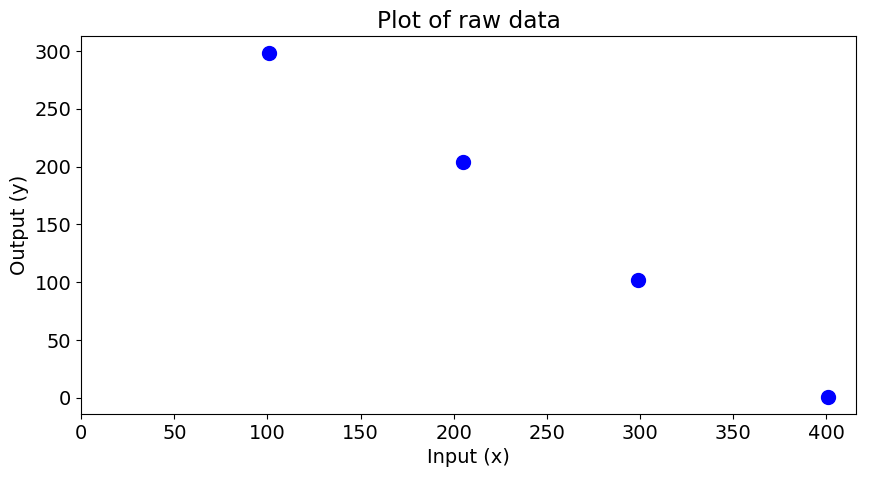

In [83]:
fig1 = plt.figure(figsize=(10,5), dpi=100)
x_name = 'x'
y_name = 'y'
plt.rc("font", size=14)
plt.plot(x,y,'.',markersize=20,color='blue',label='Inline label')
plt.xlim(left=0)
plt.xlabel("Input (%s)"%(x_name))
plt.ylabel("Output (%s)"%(y_name))
plt.title("Plot of raw data")

Notice that the datapoints follow roughly a staight line of "best fit," which does not pass through the origin! The y-intercept of this line with the origin is exactly the *bias* term.

Now let's find the slope *w* and bias *b* of this linear regression model analytically using the **psuedoinverse**. First we create the input matrix, $X$, which has a column of ones as its left-most column to account for bias.

In [84]:
ones_column = np.ones([x.shape[0],1])
x = x.reshape(-1,1) # reshape the x array from 1d to 2d
X = np.concatenate((ones_column,x),axis=1)
W = np.dot(np.linalg.pinv(X),y)
print(W)

[402.35050284  -0.99841154]


Therefore the line of best fit has a bias and slope of approximately $400$ and $-1$, respectively. Now let's predict the $\hat{y}$ values from this linear regression model, and see how well they match against the actual $y$ values:

In [85]:
X

array([[  1., 101.],
       [  1., 205.],
       [  1., 299.],
       [  1., 401.]])

Text(0.5,1,'Plot of actual data vs predicted')

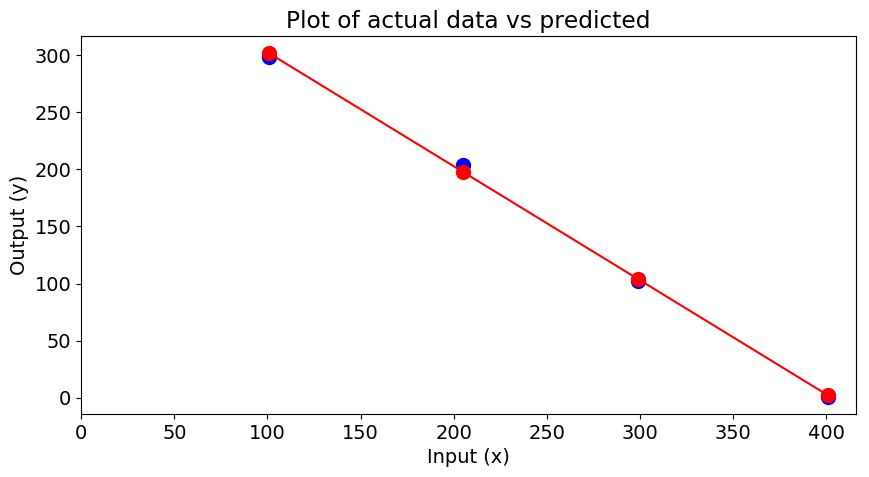

In [86]:
y_hat = np.dot(X,W) # calculate predictions based on linear regression model

fig2 = plt.figure(figsize=(10,5), dpi=100)
x_name = 'x'
y_name = 'y'
plt.rc("font", size=14)
plt.plot(x,y,'.',markersize=20,color='blue',label='Inline label')
plt.plot(x,y_hat,'-r.',markersize=20,color='red',label='Inline label')
plt.xlim(left=0)
plt.xlabel("Input (%s)"%(x_name))
plt.ylabel("Output (%s)"%(y_name))
plt.title("Plot of actual data vs predicted")

Our linear regression model in this case is pretty accurate, since the raw data itself is fairly linear. However, what if the raw data wasn't as well-behaved? Let's discuss this case in detail in the section below!

# Using regularizers to mitigate outlier-effects and overfitting

Suppose the raw data we used to start with had an **outlier**, a point that deviates far from the linear relationship formed by the remaining points.

In [49]:
# Define some arbitrary datapoints
values = np.array([[101,298],[205,400],[299,102],[401,1]])
df = pd.DataFrame(data = values,columns = ['x','y'])

x = df['x'].values
y = df['y'].values

df

,x,y
0,101,298
1,205,400
2,299,102
3,401,1


Text(0.5,1,'Plot of raw data')

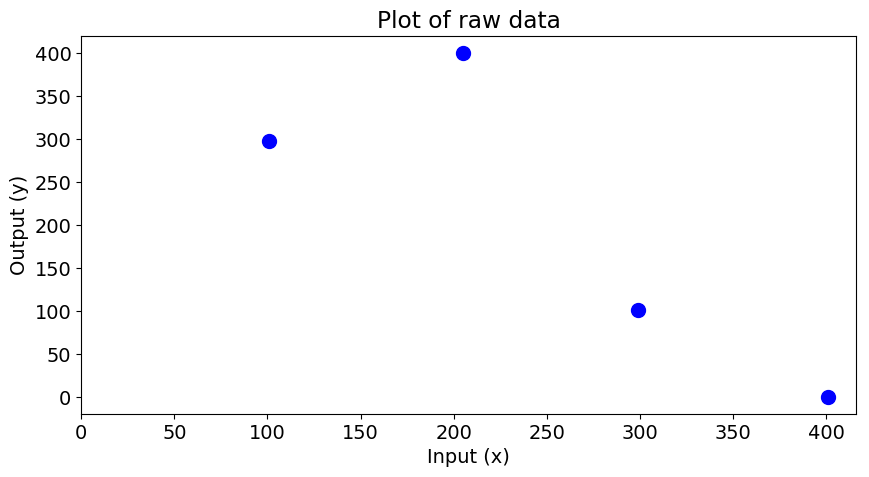

In [50]:
fig3 = plt.figure(figsize=(10,5), dpi=100)
x_name = 'x'
y_name = 'y'
plt.rc("font", size=14)
plt.plot(x,y,'.',markersize=20,color='blue',label='Inline label')
plt.xlim(left=0)
plt.xlabel("Input (%s)"%(x_name))
plt.ylabel("Output (%s)"%(y_name))
plt.title("Plot of raw data")

Notice how the second datapoint is a clear **outlier**. If it is used in the linear regression model, it would skew the model heavily! Let's observe this phenomenon by building a least-squares model using the raw data, naively.

Text(0.5,1,'Plot of actual data vs predicted')

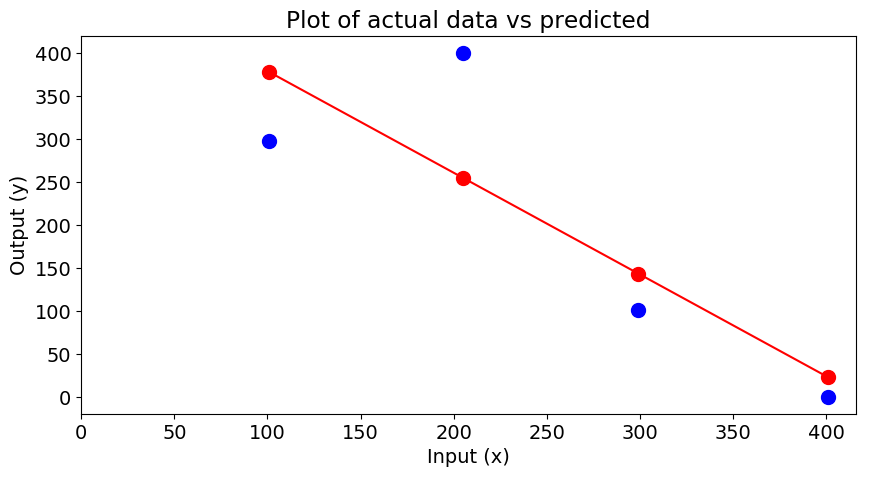

In [70]:
ones_column = np.ones([x.shape[0],1])
x = x.reshape(-1,1) # reshape the x array from 1d to 2d
X = np.concatenate((ones_column,x),axis=1)
W = np.dot(np.linalg.pinv(X),y)

y_hat = np.dot(X,W) # calculate predictions based on linear regression model

fig4 = plt.figure(figsize=(10,5), dpi=100)
x_name = 'x'
y_name = 'y'
plt.rc("font", size=14)
plt.plot(x,y,'.',markersize=20,color='blue',label='Inline label')
plt.plot(x,y_hat,'-r.',markersize=20,color='red',label='Inline label')
plt.xlim(left=0)
plt.xlabel("Input (%s)"%(x_name))
plt.ylabel("Output (%s)"%(y_name))
plt.title("Plot of actual data vs predicted")

We can see that the model has deviated from the true linear behaviour of the three remaining, "well-behaved" points. Specifically, the bias term in the model is erroneous. 

Note that the **outlier** measurement (i.e. the second datapoint) may have been taken in error - due to a malfunctioning sensor or human mistake, for example. So how do we retain the "true" underlying linear relationship of the remaining datapoints? The answer is to use a neat tool called a **regularizer**, which can be interpreted mathematically as a **penalty on the magnitude of model weights.** If we re-write the least-squares objective with the **regularizer**, it has the form of:

$$\underset{W}{min} \bigg[ \lvert \lvert XW-y \rvert \rvert_2^2 + \frac{\lambda}{2}\lvert \lvert W \rvert \rvert_2^2 \bigg]$$

This can be interpreted geometrically as well. If we are trying to make the line fit all the datapoints (i.e. have a small residual), this line would have a large slope and bias. However, if we are trying to make the line *robust* against outliers (i.e. not necessarily have a small residual anymore) the points, the slope and bias would be small. So by penalizing the term $W$ (which also contains the bias since we augmented our $X$ matrix) in the least-squares cost function, we ensure it has a certain immunity against outliers. Increasing the *regularization constant* $\lambda$ increases the regularization effect (i.e. more penalty so more outlier-robust) but at the cost of increasing the model residual.

When we minimize the equation above, we can use the same approach: we take $\frac{\partial}{\partial W}$ on the previous equation, set it equal to zero, then see what the optimal value of $W$ is. In this case the answer is (you are recommended to do this an exercise yourself):

$$\underset{W}{arg min} \bigg[ \lvert \lvert XW-y \rvert \rvert_2^2 + \frac{\lambda}{2}\lvert \lvert W \rvert \rvert_2^2 \bigg] = (X^{\top}X+\lambda I_d)^{-1}X^{\top}y$$

Notice that this solution also introduces *numerical stability*, since sometimes $X^{\top}X$ is not invertible, but $X^{\top}X+\lambda I_N$ is guaranteed to be! Let's now try this approach on our previous example, and see if the model becomes less susceptible to the outlier.

In [59]:
np.linalg.inv(np.dot(X.T,X)+lamb*np.eye(d))

array([[ 6.04726170e-01, -2.01156148e-03],
       [-2.01156148e-03,  9.99782048e-06]])

In [60]:
y

array([298, 400, 102,   1])

Text(0.5,1,'Plot of actual data vs predicted')

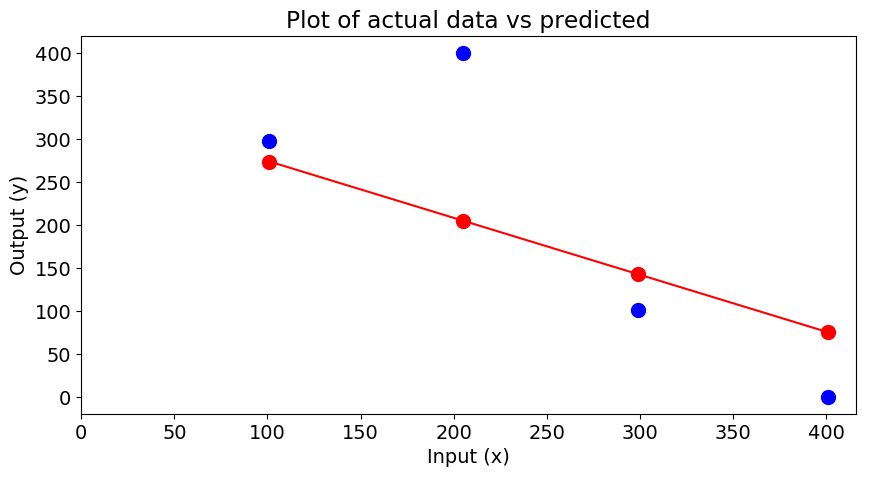

In [69]:
N = X.shape[0]
d = X.shape[1]

ones_column = np.ones([N,1])
x = x.reshape(-1,1) # reshape the x array from 1d to 2d
X = np.concatenate((ones_column,x),axis=1)
lamb = 0.3

W = (np.linalg.inv(np.dot(X.T,X)+lamb*np.eye(d))).dot(X.T).dot(y)

y_hat = X.dot(W) # calculate predictions based on linear regression model

fig4 = plt.figure(figsize=(10,5), dpi=100)
x_name = 'x'
y_name = 'y'
plt.rc("font", size=14)
plt.plot(x,y,'.',markersize=20,color='blue',label='Inline label')
plt.plot(x,y_hat,'-r.',markersize=20, label='Inline label')
plt.xlim(left=0)
plt.xlabel("Input (%s)"%(x_name))
plt.ylabel("Output (%s)"%(y_name))
plt.title("Plot of actual data vs predicted")

This is indeed a model which is more robust to the outlier. As mentioned previously, as we increase the regularization constant $\lambda$, the slope and bias of the line both decrease, and both model robustness and residuals increase:

Text(0.5,1,'Plot of actual data vs predicted')

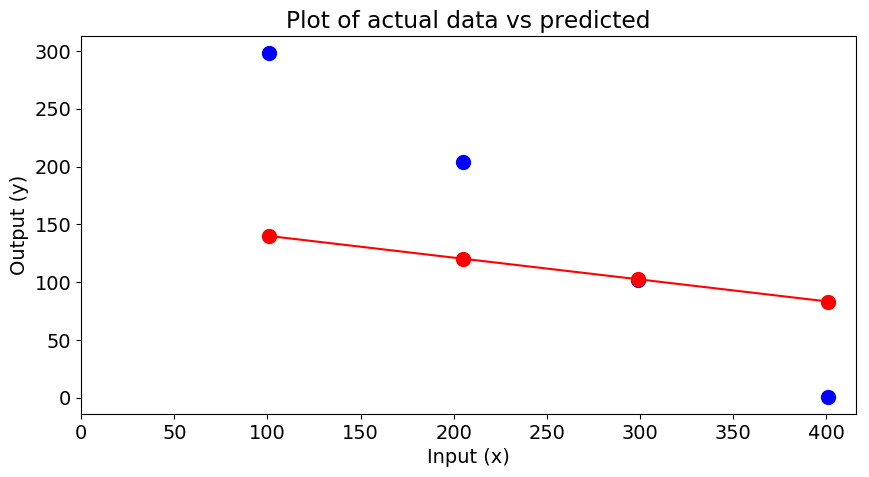

In [87]:
ones_column = np.ones([N,1])
x = x.reshape(-1,1) # reshape the x array from 1d to 2d
X = np.concatenate((ones_column,x),axis=1)
lamb = 1

W = (np.linalg.inv(np.dot(X.T,X)+lamb*np.eye(d))).dot(X.T).dot(y)

y_hat = X.dot(W) # calculate predictions based on linear regression model

fig4 = plt.figure(figsize=(10,5), dpi=100)
x_name = 'x'
y_name = 'y'
plt.rc("font", size=14)
plt.plot(x,y,'.',markersize=20,color='blue',label='Inline label')
plt.plot(x,y_hat,'-r.',markersize=20, label='Inline label')
plt.xlim(left=0)
plt.xlabel("Input (%s)"%(x_name))
plt.ylabel("Output (%s)"%(y_name))
plt.title("Plot of actual data vs predicted")

Obviusly, an optimal balance exists between model robustness and performance. The optimal value for $\lambda$ can be found by a procedure known as **cross-validation**, which will be covered in another notebook.